In [ ]:
# To download the mnist dataset 
from torchvision import datasets

In [ ]:
import os
import numpy as np

In [ ]:
from embedml.tensor import Tensor
from embedml.nn import Linear
from embedml.nn import Module
from embedml.nn import Softmax, LogSoftmax

In [ ]:
ds = datasets.MNIST('data', download=True)

In [ ]:
class dataset:
    def __init__(self, data, targets):
        super().__init__()
        self.len = len(data)
        self.data = data.view((-1, 28 * 28)).float()
        self.normalize()
        self.targets = targets

    def normalize(self):
        self.mean = self.data.mean(axis=-1, keepdim=True)
        self.std = self.data.std(axis=-1, keepdim=True)
        self.data = (self.data - self.mean) / self.std
        
    def __getitem__(self, idx):
        return Tensor(self.data[idx], requires_grad=False), Tensor(self.targets[idx], requires_grad=False)

    def __len__(self):
        return self.len

In [ ]:
def loader(dataset, bs):
    index = 0
    while index < (len(dataset) // bs):
        slc = slice(index * bs, (index + 1)* bs)
        index +=1
        yield dataset[slc]


In [ ]:
train_ds , test_ds = (ds.data[:50000], ds.targets[:50000]) , (ds.data[50000:], ds.targets[50000:])
train = dataset(*train_ds)


In [ ]:
t_dl = loader(train, 128)

In [ ]:
class simple(Module):
    def __init__(self):
        super().__init__()
        self.l1 = Linear(28*28, 32)
        self.l2 = Linear(32, 10)
        self.ac = LogSoftmax(dim=1)
    def forward(self, data):
        y0 = self.l1(data)
        y1 = self.ac(self.l2(y0))
        return y1

In [ ]:
def one_hot(label, num_classes):
    shape = label.shape[0], num_classes
    y = np.zeros(shape)
    y_ptr = y.reshape((-1,))
    idx = label.flatten() + np.arange(0, (np.prod(shape)), shape[1])
    y_ptr[idx] = 1
    return y
    

In [ ]:
class optim:
    def __init__(self, params, lr):
        self.params = params
        self.lr = Tensor(np.array(lr))
        
    def step(self):
        for param in self.params:
            param -= param.grad * self.lr
        
    def zero_grad(self):
        for param in self.params:
            param.grad = param.grad * 0

In [ ]:
class CrossEntropy(Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class
        
    def forward(self, y, target):
        T = Tensor(one_hot(target, self.num_class), requires_grad=False)
        return (y * T).sum() * -1
        

In [ ]:
m = simple()

In [ ]:
p = m.get_parameters()
opt = optim(p, 0.001)

In [ ]:
for i in range(len(p)):
    p[i].data = p[i].data * 0.001


In [ ]:
target = np.array(test_ds[1])
test = Tensor(test_ds[0].reshape((-1, 784)), requires_grad=False)

In [ ]:
criterion = CrossEntropy(num_class=10)

In [ ]:
trace = {'loss':[], 'acc':[]}

for x, t in t_dl:
    y = m(x)
    loss = criterion(y, t)
    loss.backward()   
    opt.step()
    opt.zero_grad()
    
    label = m(test).data.argmax(axis=-1)
    acc = (label == target).sum() * 100 / target.shape
    trace['loss'].append(loss.data[0][0])
    trace['acc'].append(acc[0])
print(f"{acc=}")

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Percent')

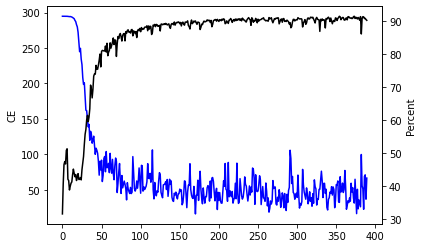

In [ ]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
l1, = ax1.plot(trace['loss'], color='blue', label='loss')
l2, = ax2.plot(trace['acc'], color='black', label='accuracy')

ax1.set_ylabel('CE')
ax2.set_ylabel('Percent')
